#Project of 'Laboratorio di Intelligenza Artificiale'
Nevi Classification with Machine Learninig for automatic diagnosis of melanoma

[![View filled on Github](https://img.shields.io/static/v1.svg?logo=github&label=Repo&message=View%20On%20Github&color=purple)](https://github.com/ValerioSpagnoli/Nevi-Classification/blob/main/Nevi_Classification.ipynb)
[![Open filled In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1e4YtGOXGq-ZCI5Iun__t99Y4HTTMuQXa?authuser=1#scrollTo=uQbBFaezBVRa)

##Import, mount on Google Drive, definition of variables

In [30]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [134]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import optimizer
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler, ConcatDataset, SubsetRandomSampler, random_split

import torchvision
from torchvision.utils import make_grid
from torchvision.models import resnet
from torchvision.models.resnet import ResNet18_Weights
from torchvision import transforms
from torchvision.transforms import AutoAugment, AutoAugmentPolicy
import torchaudio

import pandas as pd

import os

from skimage import io
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, precision_recall_curve, f1_score, roc_curve, roc_auc_score, average_precision_score
from sklearn.model_selection import KFold

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

import numpy as np
from numpy.core.fromnumeric import reshape

import seaborn as sns

import random


from google.colab import files

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [4]:
batch_size = 32
num_epochs = 8
classes = ('benign', 'malignant')

K=5
Kfolder = KFold(n_splits = K, shuffle = True)
fold_performance={}

##Class of Dataset and Loader

In [5]:
class ISIC_Dataset(Dataset):
  def __init__(self, csv_file, img_dir, transform=None, data=None, device=None):
    self.img_labels = pd.read_csv(csv_file)
    self.img_dir = img_dir
    self.transform = transform
    self.data = data
    self.code_img = None
    self.device = device

  def __len__(self):
    return len(self.img_labels)

  def __getitem__(self, idx):
    self.code_img = self.img_labels.iloc[idx, 0]
    img_path = os.path.join(self.img_dir, self.code_img) + '.jpg'
    image = io.imread(img_path)

    #benign = 0 malignant = 1
    
    if(self.data == 'Train'):
      label_bm = self.img_labels.iloc[idx, 1]
      label = 0
      if(label_bm == 'malignant'): 
        label = 1

    elif(self.data == 'Test'):
      label = self.img_labels.iloc[idx, 1].astype(np.int64)


    if self.transform:
      image = self.transform(image)

    image.to(self.device)
  
    return image, label

In [6]:
def get_dataset(data_type = None, path_csv = None, path_img = None, batch_size = None):
  
  dataset = None

  transform = transforms.Compose([transforms.ToPILImage(),
                                  transforms.Resize((800, 800)),
                                  transforms.ToTensor(),
                                  transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
  
  if data_type == "Train":
  
    dataset = ISIC_Dataset(csv_file = path_csv, img_dir = path_img, transform = transform, data = "Train", device = device)

  elif data_type == "Test":

    dataset = ISIC_Dataset(csv_file = path_csv, img_dir = path_img, transform = transform, data = "Test", device = device)
    
  if(dataset == None):
    print("Errore nel setup del dataset.")
    return

  return dataset

In [7]:
def get_aug_dataset():

  dataset = None

  path_csv = '/content/drive/MyDrive/Università/Progetto Lab IAGI/Dataset1/Training/ISBI2016_ISIC_Part3_Training_GroundTruth.csv' 
  path_img = '/content/drive/MyDrive/Università/Progetto Lab IAGI/Dataset1/Training/ISBI2016_ISIC_Part3_Training_Data'

  transform = transforms.Compose([transforms.ToPILImage(),
                                  transforms.AutoAugment(policy = AutoAugmentPolicy.IMAGENET),
                                  transforms.Resize((800, 800)),
                                  transforms.ToTensor(),
                                  transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
  
  dataset = ISIC_Dataset(csv_file = path_csv, img_dir = path_img, transform = transform, data = "Train", device = device)

  return dataset

In [9]:
def stat_dataframe(dataset_path = None):

  df = pd.read_csv(dataset_path)
    
  df_count = len(df.axes[0])

  print("Numero di dati presenti nel dataframe:", df_count, "\n\n")

  df_benign_count = df['benign'].value_counts(normalize=False)

  total_benign = df_benign_count[0]
  total_malignant = df_benign_count[1]
  
  benign_perc = round(total_benign/df_count * 100,2)
  malignant_perc = round(total_malignant/df_count * 100,2)

  print("Percentuale di benigni e maligni nel dataframe:\n")
  print("Benign: {} %".format(benign_perc))
  print("Malignant: {} %".format(malignant_perc), "\n\n")

  print("Numero di valori nulli del dataset:\n")
  print(df.isna().sum())

  return total_benign, total_malignant

In [10]:
def stat_dataset(data_type = None, dataset = None):

  num_benign = 0
  num_malignant = 0

  images = []
  labels = []

  for i in range(len(dataset)):
      image, label = dataset.__getitem__(i)
      images.append(image)
      labels.append(label)
      if(label == 0):
        num_benign += 1
      else:
        num_malignant += 1

  print("Dimensione del ", data_type+"_set: ", num_benign+num_malignant, "\n\n")

  print("Numero di nei benigni nel dataset: {}".format(num_benign))
  print("Numero di nei maligni nel dataset: {}\n\n".format(num_malignant))

  print("Percentuale di nei benigni e maligni del dataset:\n")
  print("- benign: {} %".format(round(num_benign/(num_benign+num_malignant)*100,2)))
  print("- malignant: {} %".format(round(num_malignant/(num_benign+num_malignant)*100,2)))

In [11]:
def stat_loader(data_type = None, loader = None):
  num_benign = 0
  num_malignant = 0

  for i, data in enumerate(loader, 0):
      inputs, labels = data
      inputs, labels = inputs.to(device), labels.to(device)
      for j in range(labels.size()[0]):
        if(labels[j] == 0):
          num_benign += 1
        else:
          num_malignant += 1

  print("Dimensione del ", data_type+"_set: ", num_benign+num_malignant, "\n\n")

  print("Numero di nei benigni nel dataset: {}".format(num_benign))
  print("Numero di nei maligni nel dataset: {}\n\n".format(num_malignant))

  print("Percentuale di nei benigni e maligni del dataset:\n")
  print("- benign: {} %".format(round(num_benign/(num_benign+num_malignant)*100,2)))
  print("- malignant: {} %".format(round(num_malignant/(num_benign+num_malignant)*100,2)))

In [166]:
def print_1batch(dataset = None):

  print("Stampa di 1 batch (batch_size: {}):\n".format(batch_size))
  
  images = []
  labels = []

  for i in range(len(dataset)):
      image, label = dataset.__getitem__(i)
      images.append(image)
      labels.append(label)

  images = random.sample(images, batch_size)
  labels = random.sample(labels, batch_size)

  grid = make_grid(images)
  imshow(grid)

  for i in range(batch_size):
    print("{} Label: {}".format(str(i)  + " " if i<10 else i, classes[labels[i]] + "    " if labels[i] == 0 else classes[labels[i]] + " "))

In [13]:
def imshow(img):
    img[0] = img[0]*0.485 + 0.229     # unnormalize
    img[1] = img[1]*0.456 + 0.224
    img[2] = img[2]*0.406 + 0.225
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

##Model, Training and Testing

In [164]:
def get_batch_weight(batch_labels = None):
  num_benign = 0
  num_malignant = 0

  batch_labels = batch_labels.type(torch.int64)

  for i in range(len(batch_labels)):
    if(batch_labels[i] == 0):
      num_benign+=1
    else:
      num_malignant+=1

  if num_malignant != 0:

    weight = num_benign/num_malignant
    class_weights = [1, weight]
    batch_weights = [0] * len(batch_labels)

    for i in range(len(batch_labels)):
      class_weight = class_weights[batch_labels[i]]
      batch_weights[i] = class_weight

    batch_weights = torch.Tensor(batch_weights)
  
  else:
    batch_weights = torch.ones(len(batch_labels))
  
  return reshape(batch_weights, (len(batch_labels), 1))

In [162]:
def get_model():
  model =  torchvision.models.resnet34(weights='DEFAULT')
  for params in model.parameters():
    params.requires_grad_ = True

  nr_filters = model.fc.in_features
  model.fc = nn.Linear(nr_filters, 1)

  model.to(device)

  criterion = nn.BCELoss()
  criterion.to(device)

  optimizer = optim.SGD(model.parameters(), lr = 0.0001, momentum = 0.9)
  
  return model, criterion, optimizer

In [163]:
def train_epoch(model = None, device = None, train_loader = None, criterion = None, optimizer = None):

  loss_epoch = 0
  correct_prediction_epoch = 0
  total_prediction_epoch = 0

  model.train()

  for i, data in enumerate(train_loader, 0):

    inputs, labels = data
    labels = reshape(labels, (labels.size()[0],1)).float()
    inputs, labels = inputs.to(device), labels.to(device)

    optimizer.zero_grad()

    outputs = model(inputs)
    outputs = torch.sigmoid(outputs)

    batch_weights = get_batch_weight(batch_labels = labels)
    criterion1 = nn.BCELoss(weight = batch_weights)
    criterion1.to(device)

    loss = criterion1(outputs, labels)
    loss.backward()
    
    optimizer.step()

    loss_epoch += loss.item()

    prediction = []
    target = []

    for j in range(0, labels.size()[0]):
      out = 0 #benign
      if(outputs[j]>=0.5):
        out = 1 #malignant
      
      lab = labels[j]

      prediction.append(out)
      target.append(lab.item())

      if(lab == out):
        correct_prediction_epoch += 1

      total_prediction_epoch += 1
        
  return loss_epoch, correct_prediction_epoch

In [17]:
def validation_epoch(model = None, device = None, val_loader = None, criterion = None, optimizer = None):

  loss_epoch = 0
  correct_prediction_epoch = 0
  total_prediction_epoch = 0

  model.eval()

  with torch.no_grad():

    for i, data in enumerate(val_loader, 0):

      inputs, labels = data
      labels = reshape(labels, (labels.size()[0],1)).float()
      inputs, labels = inputs.to(device), labels.to(device)

      outputs = model(inputs)
      outputs = torch.sigmoid(outputs) 

      loss = criterion(outputs, labels)

      loss_epoch += loss.item()

      for j in range(0, labels.size()[0]):
        out = 0 #benign
        if(outputs[j]>=0.5):
          out = 1 #malignant
          
        lab = labels[j]

        if(lab == out):
          correct_prediction_epoch += 1

        total_prediction_epoch += 1
      
  return loss_epoch, correct_prediction_epoch

In [174]:
def training(dataset = None, model = None, device = None, optimizer = None, criterion = None):

  total_train_loss = []
  total_train_acc = []
  total_val_loss = []
  total_val_acc = []

  print("---------------------------------------------------------------------------------------------------------------------------------")                                     
  print('-------------------------------------------------------- Start Training ---------------------------------------------------------')
  print("---------------------------------------------------------------------------------------------------------------------------------\n\n")

  for fold, (train_idx, val_idx) in enumerate(Kfolder.split(np.arange(len(dataset)))): 

    print("\n------------------------------------------------------------ Fold {} -------------------------------------------------------------\n".format(fold+1))
    
    dataset_aug = get_aug_dataset()

    train_sampler = SubsetRandomSampler(train_idx)
    val_sampler = SubsetRandomSampler(val_idx)
    train_loader = DataLoader(dataset, batch_size = batch_size, sampler = train_sampler)
    train_aug_loader = DataLoader(dataset_aug, batch_size = batch_size, sampler = train_sampler)
    val_loader = DataLoader(dataset, batch_size = batch_size, sampler = val_sampler)

    model.to(device)

    history = {'train_loss': [], 'test_loss': [],'train_acc':[],'test_acc':[]}

    num_perfect = 0
    
    for epoch in range(num_epochs):
        train_loss, train_correct = train_epoch(model, device, train_loader, criterion, optimizer)
        train_aug_loss, train_aug_correct = train_epoch(model, device, train_aug_loader, criterion, optimizer)
        val_loss, val_correct = validation_epoch(model, device, val_loader, criterion)

        train_loss = train_loss / len(train_loader.sampler)
        train_acc = train_correct / len(train_loader.sampler) * 100
        val_loss = val_loss / len(val_loader.sampler)
        val_acc = val_correct / len(val_loader.sampler) * 100

        print("Epoch:{}/{} -- Training Loss: {:.3f} - Validation Loss: {:.3f} -- Training Accuracy: {:.2f} % - Validation Accuracy: {:.2f} %".format(epoch + 1, num_epochs, train_loss, val_loss, train_acc, val_acc),"\n")

        history['train_loss'].append(train_loss)
        history['test_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['test_acc'].append(val_acc)

        total_train_loss.append(train_loss)
        total_train_acc.append(train_acc)
        total_val_loss.append(val_loss)
        total_val_acc.append(val_acc)

        if train_loss == 0 and val_loss == 0:
          num_perfect += 1

        if num_perfect == 5:
          break

    fold_performance['fold{}'.format(fold+1)] = history  

    print("\n\n")

  print("\n\n---------------------------------------------------------------------------------------------------------------------------------")                                     
  print('------------------------------------------------------- Finished Training -------------------------------------------------------')
  print("---------------------------------------------------------------------------------------------------------------------------------\n\n")

  return total_train_loss, total_train_acc, total_val_loss, total_val_acc

In [175]:
def avarage_performance():
  train_loss_avg, val_loss_avg, train_acc_avg, val_acc_avg = [], [], [], []

  for f in range(1, K+1):

      train_loss_avg.append(np.mean(fold_performance['fold{}'.format(f)]['train_loss']))
      val_loss_avg.append(np.mean(fold_performance['fold{}'.format(f)]['test_loss']))

      train_acc_avg.append(np.mean(fold_performance['fold{}'.format(f)]['train_acc']))
      val_acc_avg.append(np.mean(fold_performance['fold{}'.format(f)]['test_acc']))

  print('Performance of {} fold cross validation:'.format(K))
  print(" - Average Training Loss:       {:.3f}".format(np.mean(train_loss_avg)))
  print(" - Average Validation Loss:     {:.3f}".format(np.mean(val_loss_avg)))
  print(" - Average Training Accuracy:   {:.3f} %".format(np.mean(train_acc_avg)))
  print(" - Average Validation Accuracy: {:.3f} %".format(np.mean(val_acc_avg)))

In [23]:
def test_on_1batch(dataset = None, model = None):

  test_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

  dataiter = iter(test_loader)
  images, labels = dataiter.next()

  imshow(torchvision.utils.make_grid(images))
  
  images, labels = images.to(device), labels.to(device)

  outputs = model(images)
  outputs = torch.sigmoid(outputs)

  out = []

  for elem in outputs:
    if elem.item() >= 0.5:
      out.append(1)
    elif elem.item() < 0.5:
      out.append(0)

  print("idx | Ground Truth | Prediction")
  print("----|--------------|-----------")

  for i in range(0, batch_size):
    print(i, "  |" if i < 10 else " |", classes[labels[i]]+"     " if labels[i] == 0 else classes[labels[i]]+"  ", " |", classes[out[i]])

In [178]:
def test_and_metrics(dataset = None, model = None, total_train_loss = None, total_train_acc = None, total_val_loss = None, total_val_acc = None):
  
  test_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
  
  Y = []
  Y_hat = []
  Y_hat_prob = []

  total_train_loss = total_train_loss
  total_train_acc = total_train_acc
  total_val_loss = total_val_loss
  total_val_acc = total_val_acc

  true_benign = 0     # GT = benign and Pred = benign
  false_benign = 0    # GT = malignant and Pred = benign
  true_malignant = 0  # GT = malignant and Pred = malignant
  false_malignant = 0 # GT = benign and Pred = malignant

  with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        outputs = torch.sigmoid(outputs)

        for i in range(0, labels.size()[0]):

          lab = labels[i].item()
          out = 0
          if outputs[i][0].item()>=0.5:
            out = 1

          Y.append(lab)
          Y_hat.append(out)
          Y_hat_prob.append(outputs[i][0].item())

          if(lab == 0 and out == 0):
            true_benign += 1
          elif(lab == 1 and out == 0):
            false_benign += 1
          elif(lab == 1 and out == 1):
            true_malignant += 1
          elif(lab == 0 and out == 1):
            false_malignant += 1


  # Loss and Accuracy plots
  plt.plot(total_train_loss, label = 'training loss')
  plt.plot(total_val_loss, label = 'validation loss')
  plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
  plt.title("Training and Validation Loss", fontdict={'fontsize':16})
  plt.ylabel("Loss", fontdict={'fontsize':13})
  plt.xlabel("Num_epoch",fontdict={'fontsize':13})
  plt.rc('xtick', labelsize=12)
  plt.rc('ytick', labelsize=12)
  plt.show()

  print("\n")

  plt.plot(total_train_acc, label = 'training accuracy')
  plt.plot(total_val_acc, label = 'validation accuracy')
  plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
  plt.title("Training and Validation Accuracy", fontdict={'fontsize':16})
  plt.ylabel("Accuracy", fontdict={'fontsize':13})
  plt.xlabel("Num_epoch", fontdict={'fontsize':13})
  plt.rc('xtick', labelsize=12)
  plt.rc('ytick', labelsize=12)
  plt.show()

  print("\n\n")


  # Confusion Matrix
  cm = confusion_matrix(Y, Y_hat)
  plt.figure()
  sns.set(font_scale=1)
  hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 12}, yticklabels=['0', '1'], xticklabels=['0', '1'])
  plt.title('Confusion Matrix', fontdict={'fontsize':16})
  plt.ylabel('Ground Truth', fontdict={'fontsize':13})
  plt.xlabel('Prediction', fontdict={'fontsize':13})
  plt.show()

  print('\n')

  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
  plt.figure()
  sns.set(font_scale=1)
  hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 12}, yticklabels=['0', '1'], xticklabels=['0', '1'])
  plt.title('Confusion Matrix Normalized', fontdict={'fontsize':16})
  plt.ylabel('Ground Truth', fontdict={'fontsize':13})
  plt.xlabel('Prediction', fontdict={'fontsize':13})
  plt.show()

  print("\n\n")


  # Roc Curve and AUC
  score_fpr, score_tpr, threshold = roc_curve(Y, Y_hat_prob)
  score_roc_auc = roc_auc_score(Y, Y_hat)

  plt.plot(score_fpr, score_tpr)
  plt.title("ROC Curve", fontdict={'fontsize':16})
  plt.ylabel('True Positive Rate', fontdict={'fontsize':13})
  plt.xlabel('False Positive Rate', fontdict={'fontsize':13})
  plt.rc('xtick', labelsize=12)
  plt.rc('ytick', labelsize=12)
  plt.show()

  print("\n\n")


  # Precision and Recall Curve
  precision, recall, _ = precision_recall_curve(Y, Y_hat_prob)
  avg_precision_score = average_precision_score(Y, Y_hat_prob)

  plt.plot(recall, precision)
  plt.title("Precision-Recall Curve", fontdict={'fontsize':16})
  plt.ylabel('Precision', fontdict={'fontsize':13})
  plt.xlabel('Recall', fontdict={'fontsize':13})
  plt.rc('xtick', labelsize=12)
  plt.rc('ytick', labelsize=12)
  plt.show()  

  print("\n\n")


  # ALL METRICS

  AUC = score_roc_auc

  Average_Precision = avg_precision_score

  accuracy = (true_benign+true_malignant)/(true_benign+true_malignant+false_benign+false_malignant)

  accuracy_benign_class = true_benign/(true_benign+false_malignant)

  accuracy_malignant_class = true_malignant/(true_malignant+false_benign)

  specificity = true_benign / (false_malignant + true_benign)

  prevalence = (true_malignant + false_benign) / (true_benign+false_benign+true_malignant+false_malignant)

  sensitivity = true_malignant/(true_malignant+false_benign)

  PPV = (sensitivity * prevalence)/((sensitivity*prevalence)+((1-specificity)*(1-prevalence)))

  NPV = (specificity*(1-prevalence))/(((1-sensitivity)*prevalence) + ((specificity)*1-prevalence))

  F1_score = f1_score(Y, Y_hat)


  print("+----------------------------------------+")
  print("|  AUC :                        | {:.3f}  |".format(AUC))
  print("|-------------------------------|--------|")
  print("|  Average precision:           | {:.3f}  |".format(Average_Precision))
  print("|-------------------------------|--------|")
  print("|  Accuracy of model:           | {:.3f}  |".format(accuracy))
  print("|-------------------------------|--------|")
  print("|  Accuracy of benign class:    | {:.3f}  |".format(accuracy_benign_class))
  print("|-------------------------------|--------|")
  print("|  Accuracy of malignant class: | {:.3f}  |".format(accuracy_malignant_class))
  print("|-------------------------------|--------|")
  print("|  Sensitivity: (recall)        | {:.3f}  |".format(sensitivity))
  print("|-------------------------------|--------|")
  print("|  Specificity:                 | {:.3f}  |".format(specificity))
  print("|-------------------------------|--------|")
  print("|  Prevalence:                  | {:.3f}  |".format(prevalence))
  print("|-------------------------------|--------|")
  print("|  F1-Score:                    | {:.3f}  |".format(F1_score))
  print("|-------------------------------|--------|")
  print("|  PPV (precision):             | {:.3f}  |".format(PPV))
  print("|-------------------------------|--------|")
  print("|  NPV:                         | {:.3f}  |".format(NPV))
  print("+----------------------------------------+")

##Nevi Classification

In [35]:
train_set = get_dataset(data_type = "Train",
                        path_csv = '/content/drive/MyDrive/Università/Progetto Lab IAGI/Dataset1/Training/ISBI2016_ISIC_Part3_Training_GroundTruth.csv', 
                        path_img = '/content/drive/MyDrive/Università/Progetto Lab IAGI/Dataset1/Training/ISBI2016_ISIC_Part3_Training_Data',
                        batch_size = batch_size)

In [36]:
test_set = get_dataset(data_type = "Test",
                        path_csv = '/content/drive/MyDrive/Università/Progetto Lab IAGI/Dataset1/Test/ISBI2016_ISIC_Part3_Test_GroundTruth.csv', 
                        path_img = '/content/drive/MyDrive/Università/Progetto Lab IAGI/Dataset1/Test/ISBI2016_ISIC_Part3_Test_Data',
                        batch_size = batch_size)

In [33]:
stat_dataframe(dataset_path = '/content/drive/MyDrive/Università/Progetto Lab IAGI/Dataset1/Training/ISBI2016_ISIC_Part3_Training_GroundTruth.csv')

Numero di dati presenti nel dataframe: 900 


Percentuale di benigni e maligni nel dataframe:

Benign: 80.78 %
Malignant: 19.22 % 


Numero di valori nulli del dataset:

image_id    0
benign      0
dtype: int64


(727, 173)

In [34]:
stat_dataframe(dataset_path = '/content/drive/MyDrive/Università/Progetto Lab IAGI/Dataset1/Test/ISBI2016_ISIC_Part3_Test_GroundTruth.csv')

Numero di dati presenti nel dataframe: 379 


Percentuale di benigni e maligni nel dataframe:

Benign: 80.21 %
Malignant: 19.79 % 


Numero di valori nulli del dataset:

image_id    0
benign      0
dtype: int64


(304, 75)

Stampa di 1 batch (batch_size: 32):



0  Label: malignant 
1  Label: malignant 
2  Label: benign    
3  Label: malignant 
4  Label: benign    
5  Label: benign    
6  Label: benign    
7  Label: benign    
8  Label: benign    
9  Label: benign    
10 Label: malignant 
11 Label: benign    
12 Label: malignant 
13 Label: benign    
14 Label: benign    
15 Label: benign    
16 Label: benign    
17 Label: benign    
18 Label: benign    
19 Label: benign    
20 Label: benign    
21 Label: benign    
22 Label: benign    
23 Label: benign    
24 Label: benign    
25 Label: benign    
26 Label: benign    
27 Label: benign    
28 Label: benign    
29 Label: benign    
30 Label: benign    
31 Label: benign    


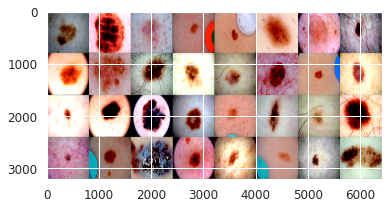

In [167]:
print_1batch(dataset = train_set)

In [44]:
model, criterion, optimizer = get_model()

In [45]:
total_train_loss, total_train_acc, total_val_loss, total_val_acc = training(dataset = train_set, model = model, device = device, optimizer = optimizer, criterion = criterion)

---------------------------------------------------------------------------------------------------------------------------------
-------------------------------------------------------- Start Training ---------------------------------------------------------
---------------------------------------------------------------------------------------------------------------------------------



------------------------------------------------------------ Fold 1 -------------------------------------------------------------

Epoch:1/8 -- Training Loss: 0.036 - Validation Loss: 0.021 -- Training Accuracy: 63.61 % - Validation Accuracy: 68.89 % 

Epoch:2/8 -- Training Loss: 0.033 - Validation Loss: 0.020 -- Training Accuracy: 64.72 % - Validation Accuracy: 68.33 % 

Epoch:3/8 -- Training Loss: 0.031 - Validation Loss: 0.020 -- Training Accuracy: 66.53 % - Validation Accuracy: 72.22 % 

Epoch:4/8 -- Training Loss: 0.029 - Validation Loss: 0.020 -- Training Accuracy: 69.72 % - Validation Accuracy

In [176]:
avarage_performance()

Performance of 5 fold cross validation:
 - Average Training Loss:       0.018
 - Average Validation Loss:     0.013
 - Average Training Accuracy:   83.049 %
 - Average Validation Accuracy: 80.889 %


idx | Ground Truth | Prediction
----|--------------|-----------
0   | benign       | benign
1   | benign       | benign
2   | benign       | benign
3   | benign       | benign
4   | benign       | benign
5   | benign       | benign
6   | benign       | benign
7   | benign       | benign
8   | benign       | benign
9   | benign       | malignant
10  | malignant    | malignant
11  | benign       | benign
12  | benign       | benign
13  | malignant    | malignant
14  | benign       | benign
15  | malignant    | malignant
16  | benign       | benign
17  | benign       | benign
18  | benign       | benign
19  | benign       | malignant
20  | benign       | benign
21  | benign       | benign
22  | benign       | benign
23  | benign       | benign
24  | benign       | benign
25  | benign       | benign
26  | benign       | malignant
27  | benign       | benign
28  | benign       | benign
29  | benign       | benign
30  | benign       | benign
31  | benign       | benign


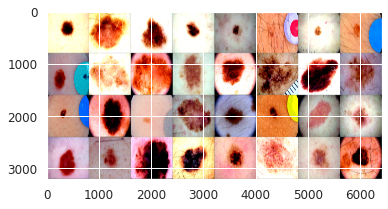

In [168]:
test_on_1batch(dataset = test_set, model = model)

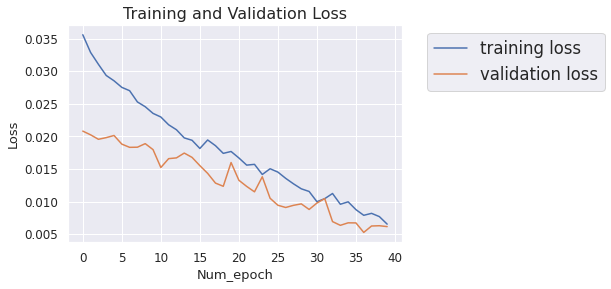

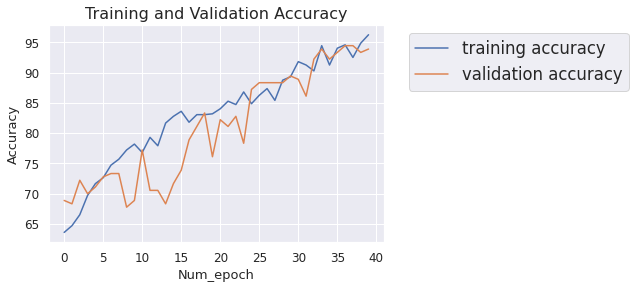

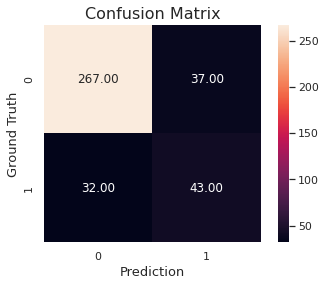

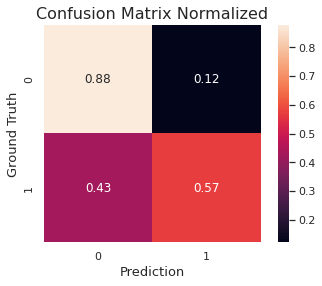

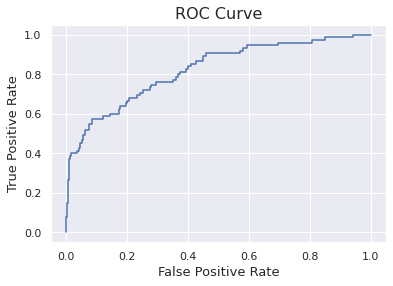

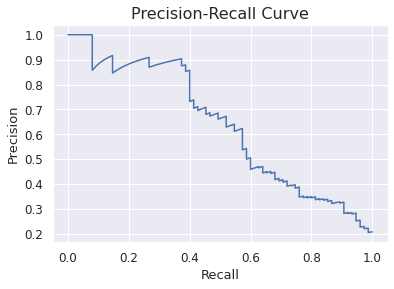




+----------------------------------------+
|  AUC :                        | 0.726  |
|-------------------------------|--------|
|  Average precision:           | 0.638  |
|-------------------------------|--------|
|  Accuracy of model:           | 0.818  |
|-------------------------------|--------|
|  Accuracy of benign class:    | 0.878  |
|-------------------------------|--------|
|  Accuracy of malignant class: | 0.573  |
|-------------------------------|--------|
|  Sensitivity: (recall)        | 0.573  |
|-------------------------------|--------|
|  Specificity:                 | 0.878  |
|-------------------------------|--------|
|  Prevalence:                  | 0.198  |
|-------------------------------|--------|
|  F1-Score:                    | 0.555  |
|-------------------------------|--------|
|  PPV (precision):             | 0.537  |
|-------------------------------|--------|
|  NPV:                         | 0.921  |
+----------------------------------------+


In [160]:
test_and_metrics(dataset = test_set, model = model, total_train_loss = total_train_loss, total_train_acc = total_train_acc, total_val_loss = total_val_loss, total_val_acc = total_val_acc)

In [177]:
torch.save(model, '/content/drive/MyDrive/Università/Progetto Lab IAGI/model.pt')